# Import des bibliothèques nécessaires

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
import lightgbm as lgb
from prettytable import PrettyTable
from colorama import Fore, Style

# Data

In [ ]:
# Charger les données depuis le fichier Excel
data = pd.read_excel('/content/german_credit_data.xlsx')

data.head()


,Age,Genre,Travail,Logement,Compte_Epargne,Compte_Chèque,Montant_Credit,Duration,Objet,Risque
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


# Statistiques descriptives

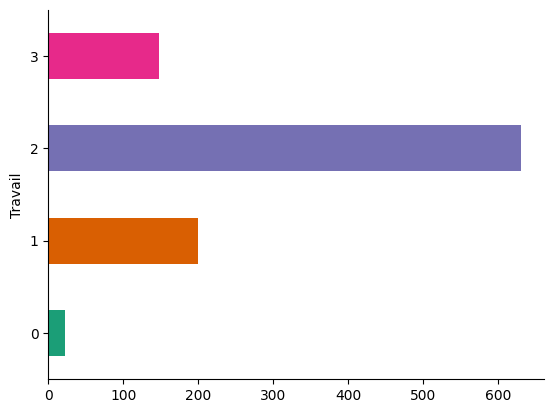

In [ ]:
# @title Travail
data.groupby('Travail').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

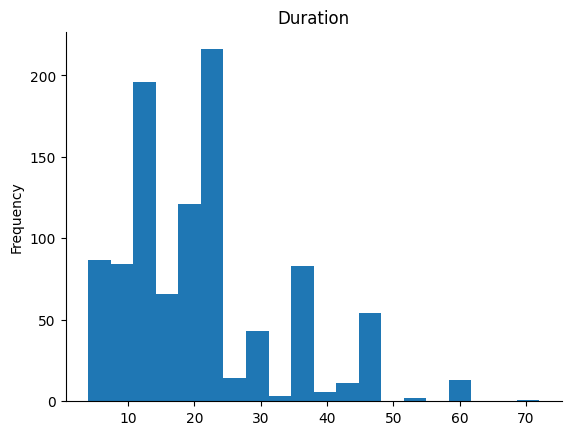

In [ ]:
# @title Duration

data['Duration'].plot(kind='hist', bins=20, title='Duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

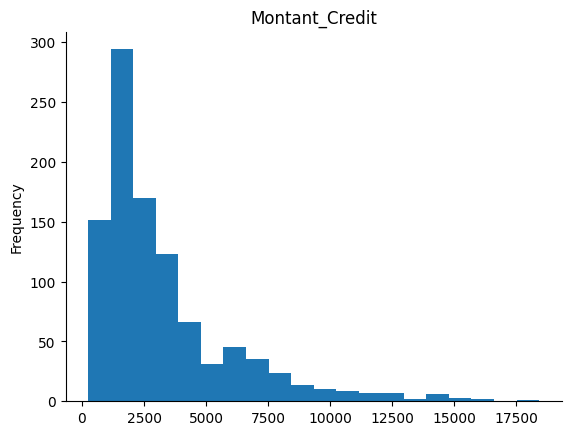

In [ ]:
# @title Montant_Credit

data['Montant_Credit'].plot(kind='hist', bins=20, title='Montant_Credit')
plt.gca().spines[['top', 'right',]].set_visible(False)

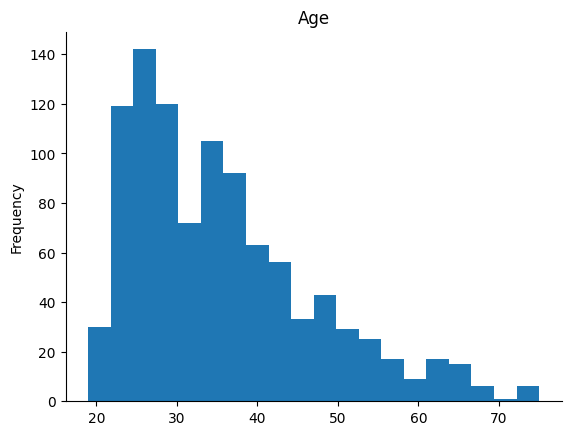

In [ ]:
# @title Age

data['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

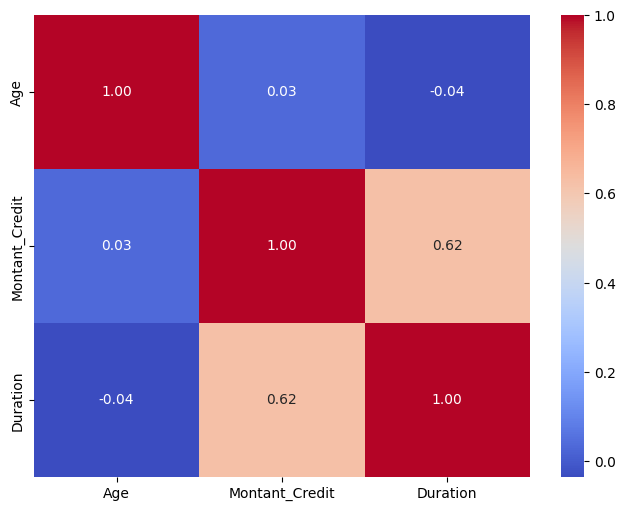

In [ ]:
# Calcul de la corrélation de Pearson entre les variables quantitatives

# Sélectionner les variables spécifiques
donnees_selectionnees = data[['Age', 'Montant_Credit', 'Duration']]

# Calcul de la matrice de corrélation entre les variables quantitatives
matrice_corr = donnees_selectionnees.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Commentaire : La corrélation positive de 0,62 entre le montant du crédit et la durée indique que la durée du prêt augmente, le montant du crédit tend également à augmenter.

In [ ]:
X = "Travail"
Y = "Risque"

table_contingence = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).astype(int)

# Afficher la table de contingence
print("Table de contingence :")
print(table_contingence)
print()

# Calculer le test du chi-deux
stat, p_value, dof, expected = chi2_contingency(table_contingence)
print("Statistique du test du chi-deux :", stat)
print("Valeur-p :", p_value)
print("Degrés de liberté :", dof)

Table de contingence :
Risque   bad  good
Travail           
0          7    15
1         56   144
2        186   444
3         51    97

Statistique du test du chi-deux : 1.8851560280131707
Valeur-p : 0.5965815918843431
Degrés de liberté : 3


Commentaire : Il n'y a pas de relation significative entre le travail et le risque de crédit, car p_value=0.6 > 5%

# Transformation des données

In [ ]:
# Sélectionner les données quantitatives
Numerical_data = data[['Age', 'Travail', 'Montant_Credit', 'Duration']]
scaler= StandardScaler()
# Appliquer la standardisation
Data_standard = scaler.fit_transform(Numerical_data)
print(Data_standard)

[[ 2.76645648  0.14694918 -0.74513141 -1.23647786]
 [-1.19140394  0.14694918  0.94981679  2.24819436]
 [ 1.18331231 -1.38377145 -0.41656241 -0.73866754]
 ...
 [ 0.21583532  0.14694918 -0.87450324 -0.73866754]
 [-1.10345149  0.14694918 -0.50552769  1.9992892 ]
 [-0.75164167  0.14694918  0.46245715  1.9992892 ]]


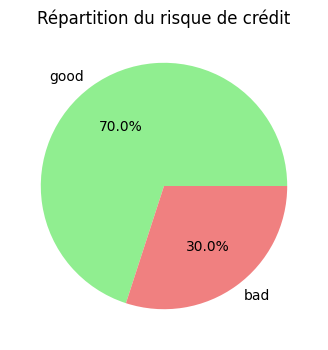

In [ ]:
# @title Risque de crédit

# Calculer les valeurs pour le diagramme circulaire
risque_counts = data['Risque'].value_counts()

# Créer le diagramme circulaire
plt.figure(figsize=(4 , 4))
plt.pie(risque_counts, labels=risque_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Répartition du risque de crédit')
plt.show()

In [ ]:
# Créer une dataframe contenant les données standardisées
df_Data_standard = pd.DataFrame(Data_standard)

# Ajouter la variable 'Risque' à la dataframe
df_Data_standard['Risque'] = data['Risque']

# Renommer les colonnes de la dataframe
df_Data_standard.columns = ['Age', 'Travail', 'Montant_Credit', 'Duration', 'Risque']

In [ ]:
df_Data_standard['Risque']=df_Data_standard['Risque'].replace({'good': 1, 'bad':0})

In [ ]:
X=df_Data_standard.drop('Risque', axis=1)
y=df_Data_standard.loc[:, ['Risque']]

In [ ]:
print(X)

          Age   Travail  Montant_Credit  Duration
0    2.766456  0.146949       -0.745131 -1.236478
1   -1.191404  0.146949        0.949817  2.248194
2    1.183312 -1.383771       -0.416562 -0.738668
3    0.831502  0.146949        1.634247  1.750384
4    1.535122  0.146949        0.566664  0.256953
..        ...       ...             ...       ...
995 -0.399832 -1.383771       -0.544162 -0.738668
996  0.391740  1.677670        0.207612  0.754763
997  0.215835  0.146949       -0.874503 -0.738668
998 -1.103451  0.146949       -0.505528  1.999289
999 -0.751642  0.146949        0.462457  1.999289

[1000 rows x 4 columns]


In [ ]:
print(y)

     Risque
0         1
1         0
2         1
3         1
4         0
..      ...
995       1
996       1
997       1
998       0
999       1

[1000 rows x 1 columns]


In [ ]:
# Diviser les données en 2 échantillions (Train : 70% & Test : 30%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Estimation de probabilité de défaut (PD)

## Régression logistique

In [ ]:
Logit= sm.Logit(y_train, X_train)
Model1=Logit.fit()
print(Model1.summary())

Optimization terminated successfully.
         Current function value: 0.670160
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Risque   No. Observations:                  700
Model:                          Logit   Df Residuals:                      696
Method:                           MLE   Df Model:                            3
Date:                Thu, 09 May 2024   Pseudo R-squ.:                -0.09926
Time:                        17:54:39   Log-Likelihood:                -469.11
converged:                       True   LL-Null:                       -426.75
Covariance Type:            nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.2552      0.080      3.180      0.001       0.098       0.412
Travail          

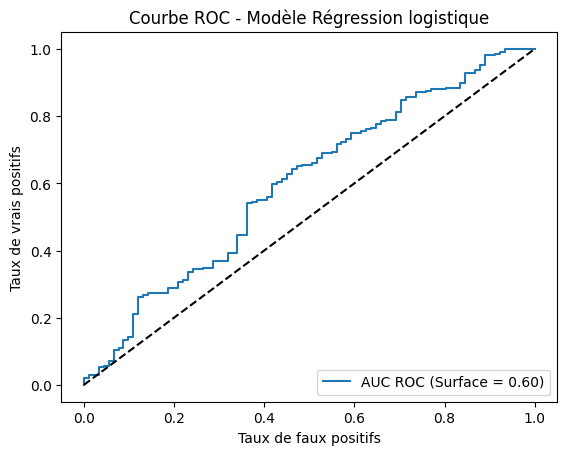

In [ ]:
# Prédire les probabilités sur l'ensemble de test
y_pred_proba = Model1.predict(X_test)

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Courbe ROC

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='AUC ROC (Surface = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Modèle Régression logistique')
plt.legend(loc='lower right')
plt.show()


## SVM

In [ ]:
# Créer le modèle SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', probability=True)

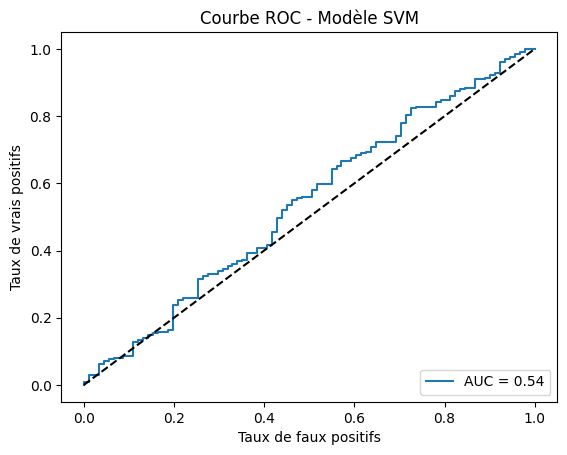

In [ ]:
# Estimer les probabilités des données de test
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculer le score AUC-ROC
auc_roc_svm = roc_auc_score(y_test, y_proba_svm)

# Calculer la courbe ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

# Courbe ROC
plt.plot(fpr_svm, tpr_svm, label=f'AUC = {auc_roc_svm:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillés pour la référence aléatoire
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Modèle SVM')
plt.legend(loc='lower right')
plt.show()

## Forêtes aléatoires

<ipython-input-65-27671036df3c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


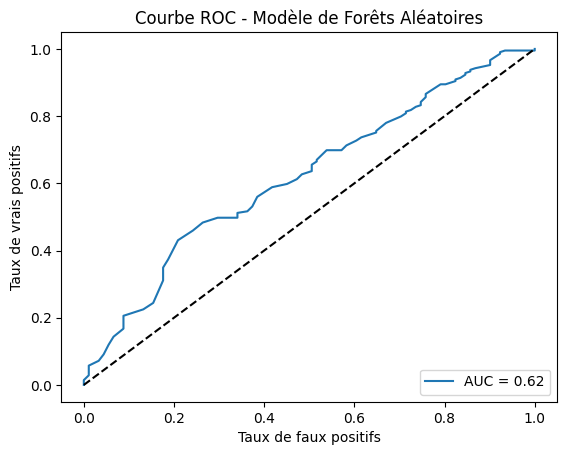

In [ ]:
# Créer le modèle de forêt aléatoire
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Estimer les probabilités des données de test
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculer le score AUC-ROC
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)

# Calculer la courbe ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# Courbe ROC
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_roc_rf:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillés pour la référence aléatoire
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Modèle de Forêts Aléatoires')
plt.legend(loc='lower right')
plt.show()


## Réseau de neurones

10/10 [==============================] - 0s 3ms/step


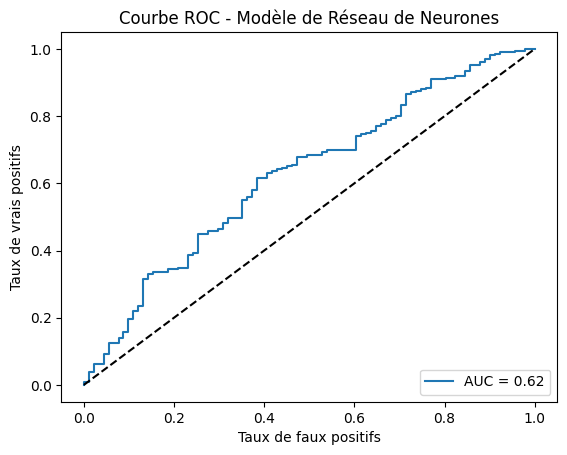

In [ ]:
# Créer le modèle de réseau de neurones
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Obtenir les prédictions brutes
y_pred_nn = model.predict(X_test)

# Appliquer la fonction sigmoïde pour obtenir les probabilités
y_proba_nn = 1 / (1 + np.exp(-y_pred_nn))

# Calculer le score AUC-ROC
auc_roc_nn = roc_auc_score(y_test, y_proba_nn)

# Calculer la courbe ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)

# Courbe ROC
plt.plot(fpr_nn, tpr_nn, label=f'AUC = {auc_roc_nn:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillés pour la référence aléatoire
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Modèle de Réseau de Neurones')
plt.legend(loc='lower right')
plt.show()


## XGBoost


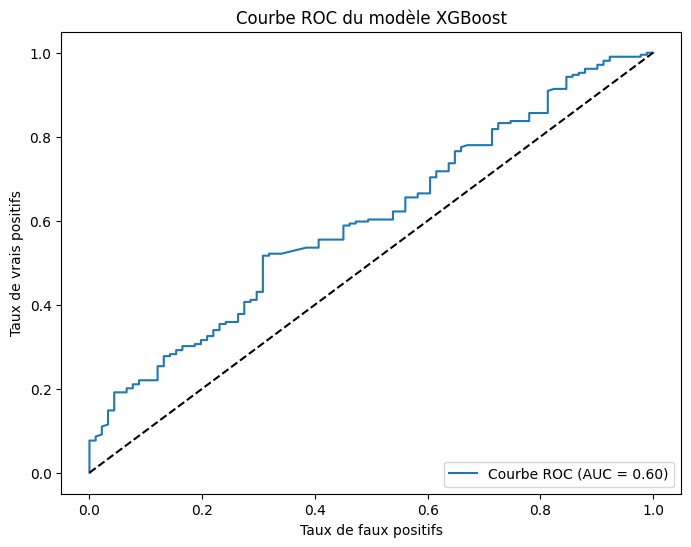

In [ ]:
# Créer le modèle XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Entraîner le modèle
model_xgb.fit(X_train, y_train)

# Prédire les probabilités des données de test
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Calculer le score AUC-ROC
auc_roc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Courbe ROC (AUC = %0.2f)' % auc_roc_xgb)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC du modèle XGBoost')
plt.legend(loc="lower right")
plt.show()

## LightGBM

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 491, number of negative: 209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701429 -> initscore=0.854110
[LightGBM] [Info] Start training from score 0.854110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

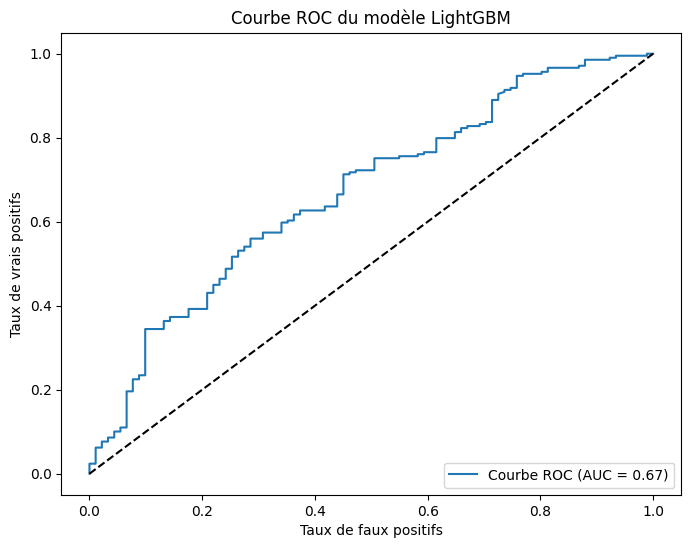

In [ ]:
# Créer le modèle LightGBM
model_lgb = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Entraîner le modèle
model_lgb.fit(X_train, y_train)

# Prédire les probabilités des données de test
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

# Calculer le score AUC-ROC
auc_roc_lgb = roc_auc_score(y_test, y_proba_lgb)

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgb)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Courbe ROC (AUC = %0.2f)' % auc_roc_lgb)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC du modèle LightGBM')
plt.legend(loc="lower right")
plt.show()

# Conclusion

In [ ]:
# Créer un tableau
table = PrettyTable()

# Ajouter des colonnes
table.field_names = ["Modèle", "AUC"]

# Ajouter des données avec LightGBM en bleu
table.add_row([f"{Fore.BLUE}LightGBM{Style.RESET_ALL}", f"{Fore.BLUE}0.67{Style.RESET_ALL}"])
table.add_row(["Réseau de neurones", 0.62])
table.add_row(["Forêts aléatoires", 0.62])
table.add_row(["XGBoost", 0.60])
table.add_row(["Régression logistique", 0.60])
table.add_row([f"{Fore.RED}SVM{Style.RESET_ALL}", f"{Fore.RED}0.54{Style.RESET_ALL}"])

# Afficher le tableau
print(table)

+-----------------------+------+
|         Modèle        | AUC  |
+-----------------------+------+
|        LightGBM       | 0.67 |
|   Réseau de neurones  | 0.62 |
|   Forêts aléatoires   | 0.62 |
|        XGBoost        | 0.6  |
| Régression logistique | 0.6  |
|          SVM          | 0.54 |
+-----------------------+------+



Parmi les modèles déployés, **LightGBM** a obtenu le meilleur score avec **0,67**, suivi du réseau de neurones et des forêts aléatoires avec 0,62. Pour renforcer la précision des modèles, nous pouvons utiliser la validation croisée. Cette technique permet d'évaluer la capacité du modèle à généraliser sur de nouvelles données et à réduire les biais.

L'estimation de la probabilité de défaut est un élément crucial pour la gestion du risque de crédit et est utilisée de diverses manières :


* **Tarification des prêts :** Déterminer les taux d'intérêt en fonction du risque de crédit. Les emprunteurs à risque élevé se voient généralement facturer des taux plus élevés.
* **Provisionnement et adéquation du capital :** Estimer les provisions et le capital nécessaires pour couvrir les pertes potentielles liées au crédit. Les régulateurs exigent des institutions financières qu'elles disposent de suffisamment de capital pour faire face au risque de crédit.
* **Gestion du portefeuille de crédit :** Surveiller et gérer le risque de crédit global du portefeuille. Identifier les concentrations de risques et mettre en œuvre des stratégies pour atténuer ces risques.
* **Décision en matière de crédit :** Aider à prendre des décisions de prêt éclairées en évaluant la solvabilité des emprunteurs. Les institutions financières peuvent utiliser les estimations de PD pour fixer des limites de crédit, approuver ou refuser des demandes de prêt et déterminer les exigences de garantie appropriées.